In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install --upgrade torch==1.9.1+cu111 torchvision==0.10.1+cu111 -f https://download.pytorch.org/whl/torch_stable.html
!git clone https://github.com/NVlabs/stylegan3
!git clone https://github.com/openai/CLIP
!pip install -e ./CLIP
!pip install einops ninja
# !git clone https://github.com/ShDee07/CelebA256Dataset.git
!git clone https://github.com/richzhang/PerceptualSimilarity

#MetaCLIP
!git clone https://github.com/facebookresearch/MetaCLIP.git

#Multilingual clip
!git clone https://github.com/FreddeFrallan/Multilingual-CLIP.git
!pip install ftfy regex tqdm
!pip install gradio
!pip install googletrans-py

### **Text-to-face generation with MetaCLIP and StyleGAN2-Ada**

In [ ]:
import sys
sys.path.append('./CLIP')
import clip

sys.path.append('./stylegan3')
import io
import os, time, glob
import pickle
import shutil
import numpy as np
from PIL import Image
import torch
import torch.nn.functional as F
import requests
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

import unicodedata
import re
from tqdm.notebook import tqdm
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from IPython.display import display
from einops import rearrange
from google.colab import files
import torch
from PIL import Image
import sys

device = torch.device('cuda:0')
print('Using device:', device, file=sys.stderr)

Using device: cuda:0


In [ ]:
def norm1(prompt):
    "Normalize to the unit sphere."
    return prompt / prompt.square().sum(dim=-1,keepdim=True).sqrt()

def loss_func(x, y):
    x = F.normalize(x, dim=-1)
    y = F.normalize(y, dim=-1)
    return (x - y).norm(dim=-1).div(2).arcsin().pow(2).mul(2)

def prompts_dist_loss(x, targets, loss):
    if len(targets) == 1:
      return loss(x, targets[0])
    distances = [loss(x, target) for target in targets]
    # print('DIST',distances)
    return torch.stack(distances, dim=-1).sum(dim=-1)

class ImageMods(torch.nn.Module):
    def __init__(self, mod_size, modn, mod_pow=1.):
        super().__init__()
        self.mod_size = mod_size
        self.modn = modn
        self.mod_pow = mod_pow

    def forward(self, input):
        sideY, sideX = input.shape[2:4]
        max_size = min(sideX, sideY)
        min_size = min(sideX, sideY, self.mod_size)
        modifications = []
        for _ in range(self.modn):
            size = int(torch.rand([])**self.mod_pow * (max_size - min_size) + min_size)
            offsetx = torch.randint(0, sideX - size + 1, ())
            offsety = torch.randint(0, sideY - size + 1, ())
            modification = input[:, :, offsety:offsety + size, offsetx:offsetx + size]
            modifications.append(F.adaptive_avg_pool2d(modification, self.mod_size))
        return torch.cat(modifications)

make_modifications = ImageMods(224, 32, 0.5)

def embed_image(image,ttf_model):
  n = image.shape[0]
  modifications = make_modifications(image)
  embeds = ttf_model.embed_modified_image(modifications)
  embeds = rearrange(embeds, '(cc n) c -> cc n c', n=n)
  return embeds

In [ ]:
import sys
sys.path.append('./CLIP')
import clip

class CLIP(object):
  def __init__(self):
    clip_model = "ViT-B/32"
    self.model, _ = clip.load(clip_model,device=device)
    self.model = self.model.requires_grad_(False)
    self.normalize = transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                                          std=[0.26862954, 0.26130258, 0.27577711])

    self.model.cuda()
  @torch.no_grad()
  def embed_text(self, prompt):
      return norm1(self.model.encode_text(clip.tokenize(prompt).to(device)).float())

  def embed_modified_image(self, image):
      return norm1(self.model.encode_image(self.normalize(image)))


import sys
sys.path.insert(0,'/content/MetaCLIP/src')
import open_clip
import torch
from PIL import Image

class MetaCLIP(object):
  def __init__(self):
    meta_clip_model = "ViT-B-32-quickgelu"
    self.model, _, self.preprocess = open_clip.create_model_and_transforms('ViT-B-32-quickgelu', pretrained='metaclip_fullcc')
    self.model = self.model.requires_grad_(False)
    self.normalize = transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                                          std=[0.26862954, 0.26130258, 0.27577711])

    self.model.cuda()
  @torch.no_grad()
  def embed_text(self, prompt):
      return norm1(self.model.encode_text(open_clip.tokenize(prompt).to(device)).float())

  def embed_modified_image(self, image):
      return norm1(self.model.encode_image(self.normalize(image)))

import sys
sys.path.insert(0,'/content/Multilingual-CLIP')
from multilingual_clip import pt_multilingual_clip
import transformers
import sys
sys.path.insert(0,'/content/CLIP')
import clip

class MultilingualCLIP(object):
  def __init__(self):
    clip_model = "ViT-B/32"
    self.model, _ = clip.load(clip_model)
    self.model = self.model.requires_grad_(False)
    self.normalize = transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                                          std=[0.26862954, 0.26130258, 0.27577711])
    multilingual_clip_model = "M-CLIP/XLM-Roberta-Large-Vit-B-32"
    self.multilingual_clip_model=pt_multilingual_clip.MultilingualCLIP.from_pretrained(multilingual_clip_model)
    self.multilingual_clip_model = self.multilingual_clip_model.requires_grad_(False)
    self.tokenizer = transformers.AutoTokenizer.from_pretrained(multilingual_clip_model,device_map = 'cuda:0')

  @torch.no_grad()
  def embed_text(self, prompt):
      "Normalized clip text embedding."
      embeddings = self.multilingual_clip_model.forward(prompt, self.tokenizer).to(device)
      return norm1(embeddings.float())

  def embed_modified_image(self, image):
      "Normalized clip image embedding."
      return norm1(self.model.encode_image(self.normalize(image)))


In [ ]:
ttf_clip_model = CLIP()
ttf_metaclip_model = MetaCLIP()
ttf_multilingualclip_model = MultilingualCLIP()

In [ ]:
my_model = "/content/drive/MyDrive/fyp/fairface240.pkl"

with open(my_model, 'rb') as fp:
  Fairface_G = pickle.load(fp)['G_ema'].to(device)

In [ ]:
def fetch_model(url):
    basename = os.path.basename(url)
    if os.path.exists(basename):
        return basename
    else:
        !wget -c '{url}'
        return basename

network_url="https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan2/versions/1/files/stylegan2-ffhq-256x256.pkl"


with open(fetch_model(network_url), 'rb') as fp:
  FFHQ_G = pickle.load(fp)['G_ema'].to(device)

In [ ]:
def model(ttf_model,targets, steps,image_path="synthesised_image"):
  image_csv_tensors = []
  image_csv_loss = []
  tf = Compose([
    Resize(224),
    lambda x: torch.clamp((x+1)/2,min=0,max=1),
    ])
  GUIImage=''

  # Find out what clamp is for
  # Sample 32 inits and choose the one closest to prompt

  # seed=22

  with torch.no_grad():
    generated_image_w_latents = []
    losses = []
    for _ in range(10):
      w_latent = G.mapping(torch.randn([4,G.mapping.z_dim], device=device), None, truncation_psi=0.7).cuda()
      images = G.synthesis(w_latent).cuda()

      embeds = embed_image(images.add(1).div(2),ttf_model).cuda()
      loss = prompts_dist_loss(embeds, targets, loss_func).mean(0)

      i = torch.argmin(loss)
      generated_image_w_latents.append(w_latent[i])
      losses.append(loss[i])

    generated_image_w_latents = torch.stack(generated_image_w_latents)
    losses = torch.stack(losses)
    i = torch.argmin(losses)
    w_latent = generated_image_w_latents[i].unsqueeze(0).requires_grad_()

  # Sampling loop
  w_latent_ema =w_latent
  opt = torch.optim.AdamW([w_latent], lr=0.03, betas=(0.0,0.999))
  loop = tqdm(range(steps))
  for i in loop:
    opt.zero_grad()
    w = w_latent
    image = G.synthesis(w, noise_mode='const').cuda()

    embed = embed_image(image.add(1).div(2),ttf_model).cuda()
    loss = prompts_dist_loss(embed, targets, loss_func).mean()
    # print('LOSS',loss)

    loss.backward()
    opt.step()
    loop.set_postfix(loss=loss.item(),w_latent_magnitude=w_latent.std().item())

    w_latent_ema =w_latent_ema * 0.9 +w_latent * 0.1
    image = G.synthesis(w_latent_ema, noise_mode='const')

    if i == (steps-1):
      pilImage=TF.to_pil_image(tf(image)[0])
      GUIImage=pilImage
      display(pilImage)

      # pilImage.save(f"/content/drive/MyDrive/FYP_Testing/FFHQ_MultilingualCLIP/lr0.03steps100/synth/{image_path}.jpg")

      pilImage.save(f"/content/{image_path}.jpg")

      image_csv_tensors.append(tf(image))
      image_csv_loss.append(loss.item())

  return image,image_csv_loss


In [ ]:
def TextToFace(ttf_model,text,steps,image_path="synthesised_image"):
  text=text.replace('.','|')
  print(text)
  targets = [ttf_model.embed_text(text)]
  # tensor_synthesised_image, image_loss,UIImage = model(ttf_model,targets, steps, 1)
  return model(ttf_model,targets, steps,image_path)


In [ ]:

text="She is caucasian and wears heavy makeup. She is attractive and has wavy hair, and black hair. The person is attractive and has arched eyebrows. The woman wears heavy makeup. She has wavy hair, and black hair. She is attractive. The person wears heavy makeup, necklace. She has arched eyebrows, and black hair. The person has wavy hair."
# text="அவள் காகசியன் மற்றும் கனமான ஒப்பனை அணிந்திருக்கிறாள். அவள் கவர்ச்சியான மற்றும் அலை அலையான முடி மற்றும் கருப்பு முடி கொண்டவள். நபர் கவர்ச்சிகரமானவர் மற்றும் வளைந்த புருவங்களைக் கொண்டவர். பெண் கனமான ஒப்பனை அணிந்துள்ளார். அவள் அலை அலையான முடி, மற்றும் கருப்பு முடி. அவள் கவர்ச்சியானவள். நபர் கனமான ஒப்பனை, நெக்லஸ் அணிந்துள்ளார். அவள் வளைந்த புருவங்கள் மற்றும் கருப்பு முடி கொண்டவள். நபருக்கு அலை அலையான முடி உள்ளது."
# ttf_model=ttf_clip_model
# ttf_model=ttf_metaclip_model
# ttf_model=ttf_multilingualclip_model





G=FFHQ_G
text_to_face_model=ttf_clip_model

TextToFace(text_to_face_model,text, 100)

In [ ]:
!pip install googletrans-py

In [ ]:
from googletrans import Translator
translator = Translator()

def translate_to_tamil(text):
    translator = Translator()
    translated_text = translator.translate(text, src='en', dest='ta')
    return translated_text.text

#Interface to translate English to Tamil
import gradio as gr
from PIL import Image

def translate(Description):
  return translate_to_tamil(Description);

# Define the Gradio interface
translationFace = gr.Interface(
    fn=translate,
    inputs=[gr.Textbox(label="Enter prompt you want to translate")],
    outputs=[gr.Textbox(label="Translated text")],
    title="Translate English description to Tamil",
)

In [ ]:
def convert_text_to_face(Description, CLIPmodel,StyleGANModel):
    if(StyleGANModel=="Fairface dataset"):
      G=Fairface_G
    elif(StyleGANModel=="FFHQ dataset"):
      G=FFHQ_G

    img = Image.open("synthesised_image.jpg")
    if(CLIPmodel=="CLIP"):
      lpips_loss,clip_loss=TextToFace(ttf_clip_model,Description, 100)
    elif(CLIPmodel=="MetaCLIP"):
      lpips_loss,clip_loss=TextToFace(ttf_metaclip_model,Description, 100)
    elif(CLIPmodel=="Multilingual-CLIP"):
      lpips_loss,clip_loss=TextToFace(ttf_multilingualclip_model,Description, 100)
    img = Image.open("synthesised_image.jpg")
    # synthesised_image=Image.open("synthesised_image.jpg")
    return img,clip_loss[0]  # Return the opened image

# Define the Gradio interface
IndividualModelFace = gr.Interface(
    fn=convert_text_to_face,
    inputs=["text",gr.Radio(["CLIP", "MetaCLIP", "Multilingual-CLIP"]),gr.Radio(["Fairface dataset", "FFHQ dataset"])],
    outputs=[gr.Image(height=256,width=256,label="Synthesised Image"),gr.Textbox(label="Loss")],
    title="Individual CLIP models",
    description="Enter your prompt and generate a face that matches it"
)

# Launch the interface
# IndividualModelFace.launch(debug=False)

In [ ]:
import gradio as gr
from PIL import Image

#Displaying 7 different ethnicities interface

def convert_text_to_face_ethnicity(Description, CLIPmodel,StyleGANModel):
    if(StyleGANModel=="Fairface dataset"):
      l="Fairface"
      G=Fairface_G
    elif(StyleGANModel=="FFHQ dataset"):
      l="FFHQ"
      G=FFHQ_G
    img = Image.open("synthesised_image.jpg")

    text_to_face_model=""
    if(CLIPmodel=="CLIP"):
      m="CLIP"
      text_to_face_model=ttf_clip_model
    elif(CLIPmodel=="MetaCLIP"):
      m="MetaCLIP"
      text_to_face_model=ttf_metaclip_model
    elif(CLIPmodel=="Multilingual-CLIP"):
      m="multilingualclip_model"
      text_to_face_model=ttf_multilingualclip_model

    ethnicity1=Description+". This person is White"
    ethnicity2=Description+". This person is African"
    ethnicity3=Description+". This person is Indian"
    ethnicity4=Description+". This person is East Asian"
    ethnicity5=Description+". This person is Southeast Asian"
    ethnicity6=Description+". This person is Middle Eastern"
    ethnicity7=Description+". This person is Latino"

    lpips_loss,clip_loss=TextToFace(text_to_face_model,ethnicity1, 100,"ethnicity1")
    lpips_loss,clip_loss=TextToFace(text_to_face_model,ethnicity2, 100,"ethnicity2")
    lpips_loss,clip_loss=TextToFace(text_to_face_model,ethnicity3, 100,"ethnicity3")
    lpips_loss,clip_loss=TextToFace(text_to_face_model,ethnicity4, 100,"ethnicity4")
    lpips_loss,clip_loss=TextToFace(text_to_face_model,ethnicity5, 100,"ethnicity5")
    lpips_loss,clip_loss=TextToFace(text_to_face_model,ethnicity6, 100,"ethnicity6")
    lpips_loss,clip_loss=TextToFace(text_to_face_model,ethnicity7, 100,"ethnicity7")

    img1 = Image.open("ethnicity1.jpg")
    img2 = Image.open("ethnicity2.jpg")
    img3 = Image.open("ethnicity3.jpg")
    img4 = Image.open("ethnicity4.jpg")
    img5 = Image.open("ethnicity5.jpg")
    img6 = Image.open("ethnicity6.jpg")
    img7 = Image.open("ethnicity7.jpg")

    # img = Image.open("synthesised_image.jpg")
    # synthesised_image=Image.open("synthesised_image.jpg")
    return img1,img2,img3,img4,img5,img6,img7  # Return the opened image

# # Define the Gradio interface
ethnicityFace = gr.Interface(
    fn=convert_text_to_face_ethnicity,
    inputs=["text",gr.Radio(["CLIP", "MetaCLIP", "Multilingual-CLIP"]),gr.Radio(["Fairface dataset", "FFHQ dataset"])],
    outputs=[gr.Image(height=256,width=256,label="White"),gr.Image(height=256,width=256,label="African"),gr.Image(height=256,width=256,label="Indian"),gr.Image(height=256,width=256,label="East Asian"),gr.Image(height=256,width=256,label="South East Asian"),gr.Image(height=256,width=256,label="Middle Eastern"),gr.Image(height=256,width=256, label="Latino")],
    title="Generated Images in 7 ethnicities",
    description="Enter a single prompt to generate 7 different faces"
)

# Launch the interface
# ethnicityFace.launch(debug=True)

In [ ]:
import gradio as gr
from PIL import Image

#Displaying 7 different ethnicities interface

def show_each_model_with_loss_graph(Description, StyleGANModel):
    if(StyleGANModel=="Fairface dataset"):
      G=Fairface_G
    elif(StyleGANModel=="FFHQ dataset"):
      G=FFHQ_G

    lpips_loss,clip_loss=TextToFace(ttf_clip_model,Description, 100,"clip")
    lpips_loss,clip_loss=TextToFace(ttf_metaclip_model,Description, 100,"metaclip")
    lpips_loss,clip_loss=TextToFace(ttf_multilingualclip_model,Description, 100,"multilingualclipEN")
    lpips_loss,clip_loss=TextToFace(ttf_multilingualclip_model,translate_to_tamil(Description), 100,"multilingualclipTA")

    img1 = Image.open("clip.jpg")
    img2 = Image.open("metaclip.jpg")
    img3 = Image.open("multilingualclipEN.jpg")
    img4 = Image.open("multilingualclipTA.jpg")

    return Description,img1,img2,img3,translate_to_tamil(Description),img4  # Return the opened image


chartFace = gr.Interface(
    fn=show_each_model_with_loss_graph,
    inputs=["text",gr.Radio(["Fairface dataset", "FFHQ dataset"])],
    outputs=[gr.Textbox(label="English text description"),gr.Image(height=256,width=256,label="CLIP"),gr.Image(height=256,width=256,label="MetaCLIP"),gr.Image(height=256,width=256,label="Multilingual-CLIP English"),gr.Textbox(label="Tamil text description"),gr.Image(height=256,width=256, label="Multilingual-CLIP Tamil")],
    title="Image Display",
    description="Display the input image."
)

# Launch the interface
# chartFace.launch()

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://4450591be5991f96b6.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


This woman has blonde hair and severe acne| She has a dark scar on her forehead and wears glasses


  0%|          | 0/100 [00:00<?, ?it/s]

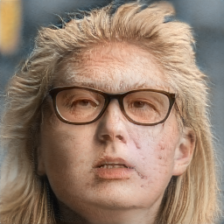

This man has brown hair and wears spectacles| He has a thick mustache and bushy eyebrows| This man has a black hair  and is smiling


  0%|          | 0/100 [00:00<?, ?it/s]

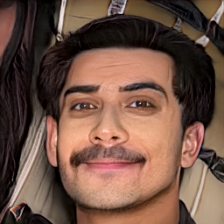

This man has brown hair and wears spectacles| He has a thick mustache and bushy eyebrows| This man has a black hair  and is smiling


  0%|          | 0/100 [00:00<?, ?it/s]

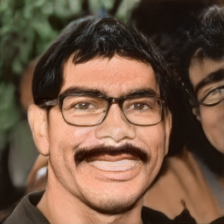

This man has brown hair and wears spectacles| He has a thick mustache and bushy eyebrows| This man has a black hair  and is smiling


  0%|          | 0/100 [00:00<?, ?it/s]

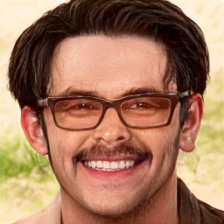

இந்த மனிதனுக்கு பழுப்பு நிற முடி உள்ளது மற்றும் கண்ணாடிகளை அணிந்துள்ளார்|அவரிடம் அடர்த்தியான மீசை மற்றும் புதர் புருவங்கள் உள்ளன|இந்த மனிதனுக்கு கருப்பு முடி உள்ளது மற்றும் புன்னகைக்கிறான்


  0%|          | 0/100 [00:00<?, ?it/s]

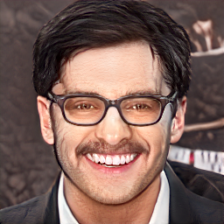

The person is attractive and has arched eyebrows| The woman wears heavy makeup| She has black hair|| This person is White


  0%|          | 0/100 [00:00<?, ?it/s]

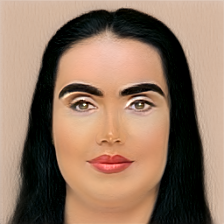

The person is attractive and has arched eyebrows| The woman wears heavy makeup| She has black hair|| This person is African


  0%|          | 0/100 [00:00<?, ?it/s]

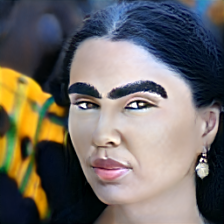

The person is attractive and has arched eyebrows| The woman wears heavy makeup| She has black hair|| This person is Indian


  0%|          | 0/100 [00:00<?, ?it/s]

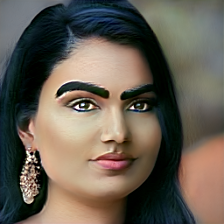

The person is attractive and has arched eyebrows| The woman wears heavy makeup| She has black hair|| This person is East Asian


  0%|          | 0/100 [00:00<?, ?it/s]

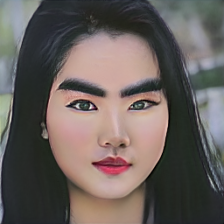

The person is attractive and has arched eyebrows| The woman wears heavy makeup| She has black hair|| This person is Southeast Asian


  0%|          | 0/100 [00:00<?, ?it/s]

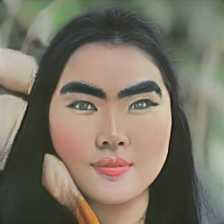

The person is attractive and has arched eyebrows| The woman wears heavy makeup| She has black hair|| This person is Middle Eastern


  0%|          | 0/100 [00:00<?, ?it/s]

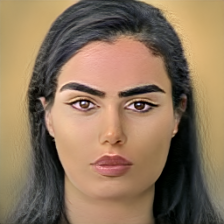

The person is attractive and has arched eyebrows| The woman wears heavy makeup| She has black hair|| This person is Latino


  0%|          | 0/100 [00:00<?, ?it/s]

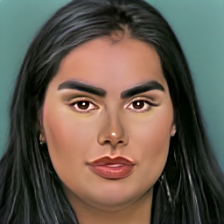

He is young and has mouth slightly open, bags under
eyes, rosy cheeks, bangs, high cheekbones, double chin, wavy hair,
and black hair|


  0%|          | 0/100 [00:00<?, ?it/s]

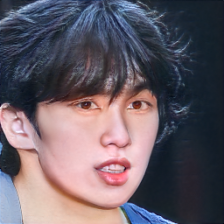

He is young and has mouth slightly open, bags under
eyes, rosy cheeks, bangs, high cheekbones, double chin, wavy hair,
and black hair|


  0%|          | 0/100 [00:00<?, ?it/s]

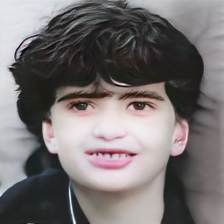

He is young and has mouth slightly open, bags under
eyes, rosy cheeks, bangs, high cheekbones, double chin, wavy hair,
and black hair|


  0%|          | 0/100 [00:00<?, ?it/s]

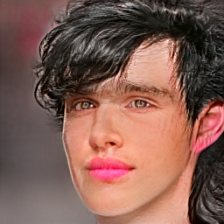

அவர் இளமையாக இருக்கிறார், வாய் சற்று திறந்திருக்கும், பைகள் கீழ் உள்ளன
கண்கள், ரோஸி கன்னங்கள், பேங்க்ஸ், உயர் கன்னம் எலும்புகள், இரட்டை கன்னம், அலை அலையான முடி,
மற்றும் கருப்பு முடி|


  0%|          | 0/100 [00:00<?, ?it/s]

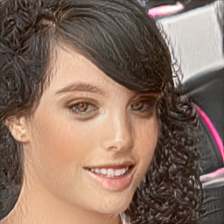

In [ ]:
gr.TabbedInterface(
    [translationFace,IndividualModelFace,ethnicityFace,chartFace], ["English to Tamil", "Individual models","7 ethnicities","All models at once"]
).launch(debug=True)